# **Debiasing Word Embeddings**

The lab that we'll be doing today is based off a widely-cited paper called [Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf), by Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai (2016).

In the paper, they demonstrate two important things:
1.   Word embeddings learn deep meanings and subtle interconnections between words, and that includes both overtly and covertly sexist meanings of words
2.   There are ways to quantify and mitigate that bias

We'll be roughly following along with the methodology of the paper — if parts of this lab are unclear or don't make sense, we strongly encourage you to read the paper and see if that clears things up.  Even if you aren't confused you should read the paper anyways (it's *super* interesting).

**Note:** The interaction between language and gender-based discrimination is a complex topic that goes far beyond our ability to quantify and vectorize words. We also recognize that gender isn't a binary, and the understanding of gender exhibited in this lab is quite naive. Regardless, there have been [well-documented instances](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon-scraps-secret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G) of programs exhibiting clearly sexist behaviors. The point of this lab is to name that dynamic and give you some tools to think about it.

## Part 0: Setup
Run this next block of code to load the dataset/embedding and other relevant imports.


In [332]:
from matplotlib import pyplot as plt
import numpy as np

For this lab, we'll be using a truncated version of the [Global Vectors for Word Representation (GloVe) word embedding](https://nlp.stanford.edu/projects/glove/) dataset. These are 300-dimensional vectors that were trained on the Wikipedia corpus circa 2014 and an open source data repository of newswire text called Gigaword 5. There are 6 billion tokens (individual words) in the corpus.

For the sake of ease, we've done some preprocessing of the data for you — instead of a 400,000-word embedding, you have a well-structured embedding of the 50,000 most common words. We've also removed all of the punctuation, and stored it compressed in the same folder as this lab so that it's accessible in Colab.

When the notebook prompts you, go to the URL in the browser and log in with your Brown email account — you'll be given a randomly generated token to paste back into this lab in order to authenticate it.

In [333]:
from google.colab import drive
drive_dir = '/content/drive'
drive.mount(drive_dir, force_remount=True) 

Mounted at /content/drive


In [334]:
import pickle

# load dataset to vector_dict (linked above)
main_dir = 'Shareddrives/CS1470 TAs Spring 2022'
lab_dir = 'Labs/Public Directory 2022/lab06_language_debiasing' ## may change
path = f'/content/drive/My Drive/preprocessed_glove.pickle'
with open(path, 'rb') as f:
    vector_dict = pickle.load(f)

Using `vector_dict` (which we just unpickled), we get a `vector_matrix` and a `word_list` with corresponding indices. These will be useful when we are trying to manually inspect some of the gender bias in GLoVe embeddings.

In [335]:
word_list = []
vector_matrix = np.zeros(shape=(50000, 300))
for i, (word, vec) in enumerate(vector_dict.items()):
  word_list.append(word)
  vector_matrix[i] = vec

print('vector_matrix of shape', vector_matrix.shape, ':\n', vector_matrix)
print('\nword_list of length',  len(word_list),      ':\n', word_list[:12])

vector_matrix of shape (50000, 300) :
 [[ 0.04656     0.21318    -0.0074364  ...  0.0090611  -0.20989
   0.053913  ]
 [-0.076947   -0.021211    0.21271    ...  0.18351    -0.29183
  -0.046533  ]
 [-0.25756    -0.057132   -0.6719     ... -0.16043     0.046744
  -0.070621  ]
 ...
 [-0.13702     0.22825     0.037058   ... -0.19953     0.31141
   0.39399   ]
 [-0.00080037  0.017533   -0.43672    ... -0.079037   -0.16981
  -0.29873   ]
 [ 0.055476   -0.34037     0.50622    ...  0.51693     0.50903
  -0.061966  ]]

word_list of length 50000 :
 ['the', 'of', 'to', 'and', 'in', 'a', 'for', 'that', 'on', 'is', 'was', 'said']


In [336]:
vector_matrix[0]

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [337]:
list(vector_dict.items())[0]

('the', array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-0

In [338]:
word_list[0]

'the'

## Part 1: The Initial Embedding

We've implemented code below that will help you clearly observe how gender functions in this word embedding. English is not a language that embeds gender into most words. That means that some of the results reflect meaningful gendered linguistic differences (between the pronouns "he" and "she", for example). Other embeddings, however, clearly illustrate the sexist biases that are a part of language. 

In [339]:
from sklearn.metrics.pairwise import linear_kernel

def find_similar(vector_matrix, input_vector, num_examples=5):
    """
    Use a basic similarity calculation (cosine similarity) to find
    the closest words to an input vector.
    """
    # compute cosine similarity of input_vector with everything else in our vocabulary 
    cosine_similarities = linear_kernel(input_vector, vector_matrix).flatten()
    cosine_similarities /= np.linalg.norm(vector_matrix, axis=1)

    # sort by cosine similarities, to get the most similar vectors on top
    related_words_indices = [i for i in cosine_similarities.argsort()[::-1]]
    return [index for index in related_words_indices][:num_examples]

def get_gendered_analogies(word, num_examples=5, vector_dict=vector_dict):
    """
    Use find_similar() to manually observe how gendered biases are encoded
    into the embedding.
    """  
    assert word in word_list, f'"{word}" not in observed vocabulary'

    print(f'He is to she as "{word}" is to: ')

    ## TODO: Get a gender-shifted vector of the input word using 
    ## the word2vec analogy method: she - he = x - word (hint: algebra)
    # x is similar to she; word is similar to he in the embedding space 

    x = vector_dict[word]
    x = np.reshape(x, (1, 300))
    # print(x.shape)
    he = np.reshape(vector_dict['he'],(1,300))
    she = np.reshape(vector_dict['she'],(1,300))
    diff_add = she - he + x    # diff_add is x here in the formula above 
                               # diff_add represents words related to her 

    gender_analogies = find_similar(vector_matrix, diff_add)
    # print(gender_analogies)
    gender = [word_list[i] for i in gender_analogies]
    print(gender)
    
    ## TODO: Get vectors similar to that input x and print out the results
    vector = vector_dict[word]
    vector = np.reshape(vector,(1,300))
    vector_similar = find_similar(vector_matrix, vector, num_examples=5)
    # print(vector_similar)
    for i in vector_similar:
        print('-', word_list[i])

get_gendered_analogies("programmer")    # TODO: Try out some different words

He is to she as "programmer" is to: 
['programmer', 'programmers', 'designer', 'actress', 'freelance']
- programmer
- programmers
- computer
- software
- animator


In [340]:
get_gendered_analogies("teacher")

He is to she as "teacher" is to: 
['teacher', 'mother', 'she', 'her', 'teachers']
- teacher
- teachers
- student
- teaching
- taught


In [341]:
get_gendered_analogies("doctor")

He is to she as "doctor" is to: 
['doctor', 'nurse', 'she', 'her', 'woman']
- doctor
- physician
- doctors
- medical
- surgeon


### **[CHECK-OFF]**

- **Expected:**
```
He is to she as "programmer" is to: 
 - programmer
 - programmers
 - ...
 ```

- Please discuss this with your TA!

Change the word in the call to `get_gendered_analogies()` to see what gendered embeddings are encoded into GloVe. Note that this is the analogy "he is to she as `input_word` is to `output_word`"; if you want to try out some of your own, `input_word` should be one that is traditionally coded as "male". (Or, you can modify your implementation of `get_gendered_analogies()` above if you want to try a word traditionally coded as "female".)

**The observed gender bias sometimes is an appropriate classifier in the situation. For example, try:**


* brother
* king
* prostate
* monastery
* masculine


**Other times the gender bias in the model reflects sexist societal stereotypes. For example, try:**
* programmer
* brilliant
* handsome
* doctor
* superstar
* snappy
* pharmaceuticals
* warrior
* genius

You should be seeing some interesting results if you've implemented `get_gendered_analogies` correctly.

In [342]:
get_gendered_analogies("prostate")

He is to she as "prostate" is to: 
['prostate', 'cancer', 'breast', 'ovarian', 'cancers']
- prostate
- cancer
- pancreatic
- tumor
- ovarian


In [343]:
get_gendered_analogies("doctor")

He is to she as "doctor" is to: 
['doctor', 'nurse', 'she', 'her', 'woman']
- doctor
- physician
- doctors
- medical
- surgeon


## Part 2: The Gender Subspace

So from some qualitative observations of which words are associated with each other, it's pretty clear that GloVe has learned sexist connotations of words. But how should we think about gender quantitatively in this embedding?

If we can come up with several vectors for words that are clearly gender-paired, we can identify a "gender subspace" of the 300-dimensional vector space that these words live in. In the paper, considered the following gender-paired, (relatively) neutral words:

- she/he
- her/his
- woman/man
- herself/himself
- daughter/son
- mother/father
- sister/brother
- gal/guy
- girl/boy
- female/male
- feminine/masculine

We can then use some observations from linear algebra to see how significant gender is in this embedding and what gender looks like quantitatively in the embedding space.

In [344]:
# generate a matrix full of random numbers to serve as a unassuming control subspace
control_subspace = np.random.randn(11, 300)
print(control_subspace.shape)
f_words = 'she her woman herself daughter mother sister  gal girl female feminine'.split()  # 11 in total 
m_words = 'he  his man   himself son      father brother guy boy  male  masculine'.split()

## Fill a matrix with the differences between the gender-paired words 
## — each entry roughly corresponds to the gender shift in this embedding
## Hint: Consider using a list comprehension [f(x) for x in iterable] and zip()

gender_subspace = np.array([
    ## TODO
    (vector_dict[x] - vector_dict[y]) for x,y in zip(f_words,m_words)    # she - he
])

gender_subspace.shape

(11, 300)


(11, 300)

Now we find and plot the covariance matrices and eigenvalues of both the control and the gender subspace matrix. 

The details and ramifications of the covariance matrix is beyond the scope of this class. If you're interested in reading up on it, consider [this mathematical guide](https://datascienceplus.com/understanding-the-covariance-matrix/) (which may also help in your implementation). 

The variance that you know and love is actually a specific case of covariance between the input matrix and itself. The more generalized ***covariance*** is the joint variability of two vectors, considering associated elements.  

All you need to know right now is that: 

 - $Cov(X) = \begin{bmatrix}
 Var(X_1) & Cov(X_1, X_2) & \cdots \\
 Cov(X_2, X_1) & Var(X_2) & \cdots  \\
 \vdots & \vdots & \ddots  \\
 \end{bmatrix}$

 - $Cov(X) \sim XX^T$ for a zero-mean matrix $X$. 
    - There's a large normalizing factor at play here which you may incorporate (see the [guide from earlier](https://datascienceplus.com/understanding-the-covariance-matrix/) (which may also help in your implementation)). It shouldn't affect the eigenpair computation though. 

Using this covariance matrix, we can compute an eigenvalue decomposition that helps to explain the following information: 
 - What vector components are used to define our subspace. 
 - How significant are those components in explaining the dataset. 

**Notes:**
- For your computation, consider taking advantage of [`np.linalg`](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html). 
- The result of this process should lead to imaginary results, please use `np.real` as appropriate to keep only the real components.

In [345]:
def get_covariance_eigs(subspace):
    '''
    TODO: Get the eigenvalues for the input subspace
    '''

    space_covariance = np.dot(np.transpose(subspace), subspace) # formula for covariance matrix  # XTX
    e_vals, e_vecs = np.linalg.eig(space_covariance)

    return space_covariance, (e_vals, e_vecs)

bias_cov, (bias_evals, bias_evecs) = get_covariance_eigs(gender_subspace)
ctrl_cov, (ctrl_evals, ctrl_evecs) = get_covariance_eigs(control_subspace)

In [346]:
bias_evecs[0].shape

(300,)

#### **Covariance Matrix Plot**

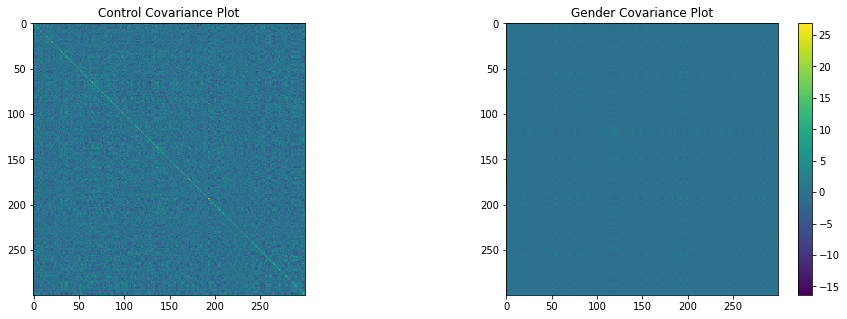

In [347]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

vmin = min(ctrl_cov.min(), bias_cov.min())
vmax = max(ctrl_cov.max(), bias_cov.max())

plot = axs[0].imshow(ctrl_cov, vmin=vmin, vmax=vmax)
axs[0].set_title('Control Covariance Plot')

plot = axs[1].imshow(bias_cov, vmin=vmin, vmax=vmax)
axs[1].set_title('Gender Covariance Plot')
fig.colorbar(plot);

#### **Eigenvalue Plot**

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


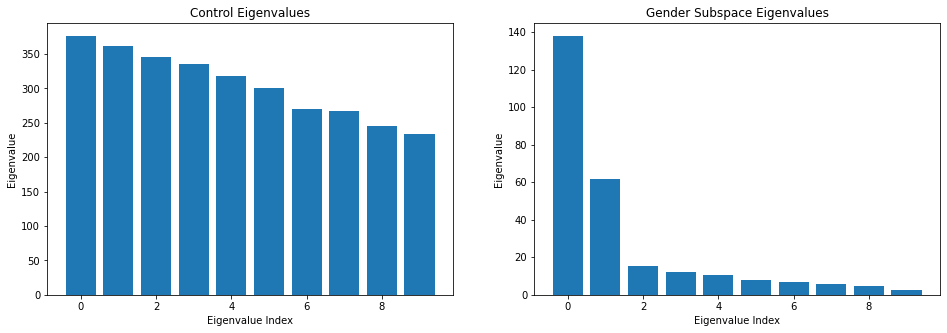

In [348]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

num_eigs = 10         ## Should yeild around 10 useful eigenpairs
x = np.arange(num_eigs) 

axs[0].bar(x, sorted(ctrl_evals[:num_eigs], reverse=True))
axs[0].set_title('Control Eigenvalues')

axs[1].bar(x, sorted(bias_evals[:num_eigs], reverse=True))
axs[1].set_title('Gender Subspace Eigenvalues');

for ax in axs:
    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Eigenvalue')

### **[CHECK-OFF]:** 

- What does the plot of the control eigenvalues look like? The gender subspace eigenvalues? What are the differences between these plots and what do those differences illustrate?

## Part 3: Debiasing
Now we're going to be debiasing the embeddings using properties of linear algebra. In this lab, we will doing a toy example — in the paper, they debias almost the entire dataset.

From part 1, we have some words that return sexist analogies that we want to debias:
* programmer
* brilliant
* handsome
* doctor
* superstar
* snappy
* pharmaceuticals
* warrior
* genius

From part 2, we also have some sense of which vectors create the "gender subspace", as well as some word-pairs that define the subspace

In the real world, the effect is more pervasive and subtle. It will likely be easier to explicitly identify the worlds that we *don't* want to debias so as to retain useful linguistic differences in gender (brother/sister, he/she, etc).

In [349]:
from sklearn.metrics.pairwise import cosine_similarity

def test_bias(vector_dict, biased_words, equality_sets):
    """
    A function that computes cosine similarities between the terms in the equality sets and the biased
    words, illustrating how the terms we've listed above are coded as more masculine than feminine.

    We will use this function again after we have debiased the biased words to illustrate what debiasing
    actually means in this context.
    """  
    f_sims = []    ## Cumulative (global) statistics
    m_sims = []
  
    # for each biased word
    for word in biased_words:
        word_f_sims = []   ## Per-word statistics
        word_m_sims = []
        
        # calculate similarity to the masculine and feminine terms in the equality sets
        for f_word, m_word in equality_sets:

            w2vec = lambda w: np.array([vector_dict[w]]) ## maps to vector mtx

            f_sim = cosine_similarity(w2vec(word), w2vec(f_word))
            m_sim = cosine_similarity(w2vec(word), w2vec(m_word))

            f_sims += [f_sim]
            m_sims += [m_sim]

            word_f_sims += [f_sim]
            word_m_sims += [m_sim]
        
        print(f'"{word}"')
        print("   Similarity female-coded words:", round(sum(word_f_sims)[0][0] / len(word_f_sims), 4))
        print("   Similarity male-coded words:", round(sum(word_m_sims)[0][0] / len(word_m_sims), 4))
        print()

    print("=================================================")
    print("Overall average similarity to female-coded words:")
    print("   ", round(sum(f_sims)[0][0] / len(f_sims), 4))
    print("—————————————————————————————————————————————————————")
    print("Overall average similarity to male-coded words:")
    print("   ", round(sum(m_sims)[0][0] / len(m_sims), 4))

# terms that have sexist encodings in GLoVe
biased_words = "programmer brilliant handsome doctor superstar brilliant"
# biased_words += " snappy pharmaceuticals warrior genius" ## More words, optional
biased_words = biased_words.split()

## Pairs of gendered terms without negative connotations.
##    To neutralize the above, we will enforce that they are
##    perpendicular to the space defined by these terms
equality_sets = list(zip(f_words, m_words))

# gives a quantitative understanding of the bias implicit in these embeddings
test_bias(vector_dict, biased_words, equality_sets)

"programmer"
   Similarity female-coded words: 0.0301
   Similarity male-coded words: 0.0987

"brilliant"
   Similarity female-coded words: 0.1412
   Similarity male-coded words: 0.2127

"handsome"
   Similarity female-coded words: 0.1731
   Similarity male-coded words: 0.2577

"doctor"
   Similarity female-coded words: 0.3067
   Similarity male-coded words: 0.3198

"superstar"
   Similarity female-coded words: 0.1508
   Similarity male-coded words: 0.1891

"brilliant"
   Similarity female-coded words: 0.1412
   Similarity male-coded words: 0.2127

Overall average similarity to female-coded words:
    0.1572
—————————————————————————————————————————————————————
Overall average similarity to male-coded words:
    0.2151


### **[CHECK-OFF]**
- What do the variable cosine similarities between the biased words and the gender-paired words show? Any first-impressions?







Up next, we're going to have to implement our projection routine. 

Here's a refresher about projection to new bases and normalization of vectors:

<img src="https://drive.google.com/uc?export=view&id=1ysNZE0cNq3Ku80x5jIjVX1uNjmTYYd9f">

In [350]:
def project(v, basis):
    out = np.zeros((300,))   ## We'll hard-code this in for clarity
    for b in basis: 
      comp = np.dot(v, b)/(np.linalg.norm(b)**2) * b
      out += np.real(comp)  ## Drop the imaginary component
    return out

def normalize(v):
  return v / np.linalg.norm(v)

We neutralize the biased words by making them orthogonal to the gender subspace that we defined above. That means that they are perpendicular to explicitly gendered vectors, and also perpendicular to the gender subspace as a whole.

---



To visualize what's happening here, let's imagine we have three vectors in 2d space: 

- The vectors for a gender-paired set of terms $v_{he}$ and $v_{she}$
- The word we have observed as having bias (e.g. "doctor"). 

Further, let's visualize the gender subspace that we've defined above as 1 vector. 

The graphic below illustrates that the cosine similarity between $v_{he}$ and $v_{doctor}$ is greater than the similarity between $v_{she}$ and $v_{doctor}$, indicating gender bias.

<img src="https://drive.google.com/uc?export=view&id=1zdlIoYpsxUwUV0Gz1CmYHoORCXtzB-7C">

What we are doing when we "neutralize" a biased term like "doctor" is:
1. Project its vector on to the gender subspace.
2. Subtract the original vector from that projection, giving us a vector that is perpendicular to the bias direction.
3. Normalize the resultant vector to conform like the others. 

After that, the neutralized vector should be roughly equidistant from both "he" and "she", and should have roughly the same cosine similarity.

<img src="https://drive.google.com/uc?export=view&id=1_EP0wofAr79bjbGm50htPP3LNGyCao3J">

In [351]:
import copy

def neutralize(vector_dict, biased_words, basis):
    '''
    Neutralize the biased word entries based on the computer eigenvectors.
    Update the resulting values in the output dictionary and return the result.
    '''
    vect_dict_w_norm = copy.deepcopy(vector_dict)

    for word in biased_words:   
        ## TODO: Implement the routine
        out = project(vect_dict_w_norm[word], basis)   # Project its vector on to the gender subspace, out is the projection 
        orh = vect_dict_w_norm[word] - out             # Subtract the original vector from that projection，
                                                       # giving us a vector that is perpendicular to the bias direction
        vect_dict_w_norm[word] = normalize(orh)        # Normalize the resultant vector to conform like the others
    
    return vect_dict_w_norm

In [352]:
num_bases = 2   ## Figure out how many bases you'd like to neutralize w.r.t.
basis = bias_evecs.T[:num_bases, :]
vect_dict_w_norm = neutralize(vector_dict, word_list, basis)

## Below can be used for fast debugging:
## will fail the get_gendered_analogies tests, but will give same normalization
# vect_dict_w_norm = neutralize(vector_dict, biased_words, basis)

print('- Original Biased "doctor" vector: [', *np.round(vector_dict     ['doctor'][:5], 4), '... ]')
print('- New Neutralized "doctor" vector: [', *np.round(vect_dict_w_norm['doctor'][:5], 4), '... ]')

- Original Biased "doctor" vector: [ -0.2021 0.075 0.0237 -0.0078 -0.2637 ... ]
- New Neutralized "doctor" vector: [ -0.0177 0.0153 0.0085 0.0024 -0.0504 ... ]


**[Check-Off]**
```
- Original Biased "doctor" vector: [ -0.2021 0.075 0.0237 -0.0078 -0.2637 ... ]
- New Neutralized "doctor" vector: [ -0.0177 0.0153 0.0085 0.0024 -0.0504 ... ]
```


Now the cosine similarities between gendered terms for the previously sexist words are all closer to zero than before. This means that the words are orthogonal to the gender subspace and (in the eyes of the model) have less gendered connotations!

In [353]:
test_bias(vect_dict_w_norm, biased_words, equality_sets)

"programmer"
   Similarity female-coded words: 0.0496
   Similarity male-coded words: 0.0528

"brilliant"
   Similarity female-coded words: 0.1661
   Similarity male-coded words: 0.1562

"handsome"
   Similarity female-coded words: 0.212
   Similarity male-coded words: 0.2114

"doctor"
   Similarity female-coded words: 0.3165
   Similarity male-coded words: 0.308

"superstar"
   Similarity female-coded words: 0.1706
   Similarity male-coded words: 0.1704

"brilliant"
   Similarity female-coded words: 0.1661
   Similarity male-coded words: 0.1562

Overall average similarity to female-coded words:
    0.1802
—————————————————————————————————————————————————————
Overall average similarity to male-coded words:
    0.1758


In [354]:
get_gendered_analogies("doctor", vector_dict=vect_dict_w_norm)

He is to she as "doctor" is to: 
['doctor', 'physician', 'doctors', 'surgeon', 'dentist']
- doctor
- physician
- doctors
- medical
- surgeon


In [355]:
get_gendered_analogies("programmer", vector_dict=vect_dict_w_norm)

He is to she as "programmer" is to: 
['programmer', 'programmers', 'animator', 'computer', 'software']
- programmer
- programmers
- computer
- software
- animator


### **[CHECK-OFF]**

- How have the cosine similarities between the biased words and the pairs of gendered words changed? What does that change signify?

- Why is it important to only project onto a basis defined by a relatively small number of influential eigenvectors?

- If we only projected a handful of words, `get_gendered_analogies` would predict something quite different despite the projection of doctor being the same. The results of this are shown below. Why might that be? 


In [356]:
vect_dict_w_subset_norm = neutralize(vector_dict, biased_words, basis)
get_gendered_analogies("doctor", vector_dict=vect_dict_w_subset_norm)

He is to she as "doctor" is to: 
['her', 'she', 'herself', 'mother', 'sister']
- doctor
- physician
- doctors
- medical
- surgeon


**Lipstick on a Pig**: Systemic Language Bias

> #### "Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them”

While the debiasing methods you practiced reduce the cosine similarity between explicitly gendered terms and biased terms, it is important to note that because gender bias is a systemic phenomenon, there are deep limitations to this form of debiasing. A [2019 paper](https://arxiv.org/pdf/1903.03862.pdf) ***“Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them”*** directly references the paper we implemented and argues:

> “Several recent works… propose methods for significantly reducing this gender bias in word embeddings, demonstrating convincing results. However, we argue that this removal is superficial. While the bias is indeed substantially reduced according to the provided bias definition, the actual effect is mostly hiding the bias, not removing it. The gender bias information is still reflected in the distances between "gender-neutralized" words in the debiased embeddings, and can be recovered from them. We present a series of experiments to support this claim, for two debiasing methods. We conclude that existing bias removal techniques are insufficient, and should not be trusted for providing gender-neutral modeling.”

We encourage you to read the full paper if you’re interested! 

Below are other excerpts that clarify the paper’s main points. 

**Why the authors believe reducing bias by its definition is an inadequate fix:**

> “… Both methods and their results rely on the specific bias definition [the projection of a word $w$ on the ‘gender direction’: $w \cdot (he - she)$]. We claim that the bias is much more profound and systematic, and that **simply reducing the projection of words on a gender direction is insufficient: it merely hides the bias**, which is still reflected in similarities between “gender-neutral” words (i.e., words such as “math” or “delicate” are in principle gender neutral, but in practice have strong stereotypical gender associations, which reflect on, and are reflected by, neighbouring words).”

**How “the actual effect is most hiding the bias, not removing it”:**

> “Our key observation is that, almost by definition, most word pairs maintain their previous similarity, despite their change in relation to the gender direction. The implication of this is that most words that had a specific bias before are still grouped together, and apart from changes with respect to specific gendered words, **the word embeddings’ spatial geometry stays largely the same**. In what follows, we provide a series of experiments that demonstrate the remaining bias in the debiased embeddings.”


### **[CHECK-OFF]**

- During the optimization routine, the model will try to optimize for the loss function in whatever way it thinks is best to minimize its error. Hence, why the bias arises in the first place. **Can you think of any techniques to neutralize bias by modifying the training of a model?** 

- Can you think of a way to ***force*** a model to have a bias of interest, or ***require*** it to incorporate specific information into its decision-making process? What might be the validity of doing that? 

- Do you have any comments on the Lipstick paper? Do you think the assertions are valid, or maybe that some of them have been handled within the scope of our experimentation? 